## Importing the libraries

In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the dataset

In [339]:
dataset = pd.read_csv('graduation_success_data.csv', sep=';')
X = dataset.drop(columns='Target')
y = dataset['Target']

## Data exploration

### Detailed dataset explanation:
##### https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

In [340]:
dataset.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [341]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

### Looking up number of rows with at least 1 missing value

In [342]:
dataset.isna().any().sum()
# The dataset doesn't have missing values 👍

0

In [343]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), name = 'Target')

## Splitting the dataset into the Training set and Test set

In [344]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Encoding categorical data

### Sorting columns by their datatypes

In [345]:
numeric_cols = [
    'Application order', 'Previous qualification (grade)', 'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP'
    ]

binary_categorical_cols = ['Daytime/evening attendance\t', 'Displaced', 'Educational special needs', 'Debtor',
                           'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']

multiclass_categorical_cols = X.drop(columns=numeric_cols).columns.difference(binary_categorical_cols)

### Encoding the dependent variable

### Encoding multiclass categorical features and scaling numerical features

In [346]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

all_cat_cols = list(multiclass_categorical_cols) + binary_categorical_cols
# categories = [sorted(X[col].unique().tolist()) for col in all_cat_cols]
ct_linear_and_mlp = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop=None), all_cat_cols), # drop=None, since unseen classes might meet in the test set.
    ('scaler', StandardScaler(), numeric_cols)
    ],
    remainder="passthrough",
)

# ct_linear_and_mlp = ColumnTransformer(transformers=[
#     ('cat', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False))
#     ]), all_cat_cols),

#     ('num', Pipeline([
#         ('imputer', SimpleImputer(strategy='mean')),
#         ('scaler', StandardScaler())
#     ]), numeric_cols)
# ], remainder='drop')

ct_linear_and_mlp.fit(X_train)

Xt_train = ct_linear_and_mlp.transform(X_train)
Xt_test = ct_linear_and_mlp.transform(X_test)

# import numpy as np
# print("Train shape:", Xt_train.shape)
# print("Test shape: ", Xt_test.shape)
# print("Any NaNs in train?", np.isnan(Xt_train).any())
# print("Any NaNs in test? ", np.isnan(Xt_test).any())
# print("Dtype:", Xt_train.dtype)

ct_tree = ColumnTransformer(
    transformers=[
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            list(multiclass_categorical_cols) + binary_categorical_cols,
        ),
    ],
    remainder="passthrough",
)

ct_prob = ColumnTransformer(
    transformers=[
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            list(multiclass_categorical_cols) + binary_categorical_cols,
        ),
        ("scale", StandardScaler(), numeric_cols),
    ],
    remainder="passthrough",
)

## Trying different models

In [347]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

pipeline = Pipeline([
    ('preprocessing', 'passthrough'),
    ('classifier', DummyClassifier())
])

param_grid = [
    {
        "preprocessing": [ct_linear_and_mlp],
        "classifier": [
            LogisticRegressionCV(max_iter=1000, random_state=23),
            SVC(kernel="linear"),
            SVC(kernel="rbf"),
        ],
    },
    {
        "preprocessing": [ct_tree],
        "classifier": [
            DecisionTreeClassifier(random_state=23),
            RandomForestClassifier(random_state=23),
            GradientBoostingClassifier(random_state=23),
        ],
    },
    {
        "preprocessing": [ct_prob],
        "classifier": [
            GaussianNB(),
        ],
    },
    {
        "preprocessing": [ct_linear_and_mlp],
        "classifier": [MLPClassifier(max_iter=1000, random_state=42, early_stopping=True)],
        "classifier__hidden_layer_sizes": [
            (100,),
            (40, 40),
            (50, 50),
            (60, 60),
            (60, 60, 60),
            (70, 70),
            (50, 50, 50),
            (100, 100)
        ],
        "classifier__activation": [
            "relu",
            "tanh"
            ],
        "classifier__alpha": [0.0001, 0.001],
    },
]

pipeline = GridSearchCV(pipeline, param_grid, cv=5, scoring="f1_macro", n_jobs=-1, error_score='raise')
pipeline.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('classifier', DummyClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegressionCV(max_iter=1000,
                                                              random_state=23),
                                         SVC(kernel='linear'), SVC()],
                          'preprocessing': [ColumnTransformer(remainder='passthrough',
                                                              transformers=[('encoder',
                                                                             OneHotEncoder(hand...
                                                                              'evaluations)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(credited)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(enrolled)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(evaluations)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(approved)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(grade)',
                                                                              'Curricular '
                                                                              'units '
                                                                              '2nd '
                                                                              'sem '
                                                                              '(without '
                                                                              'evaluations)',
                                                                              'Unemployment '
                                                                              'rate',
                                                                              'Inflation '
                                                                              'rate',
                                                                              'GDP'])])]}],
    

## Models comparison

### Evaluating the models by $ \mathbb{F}^ 1 $ score

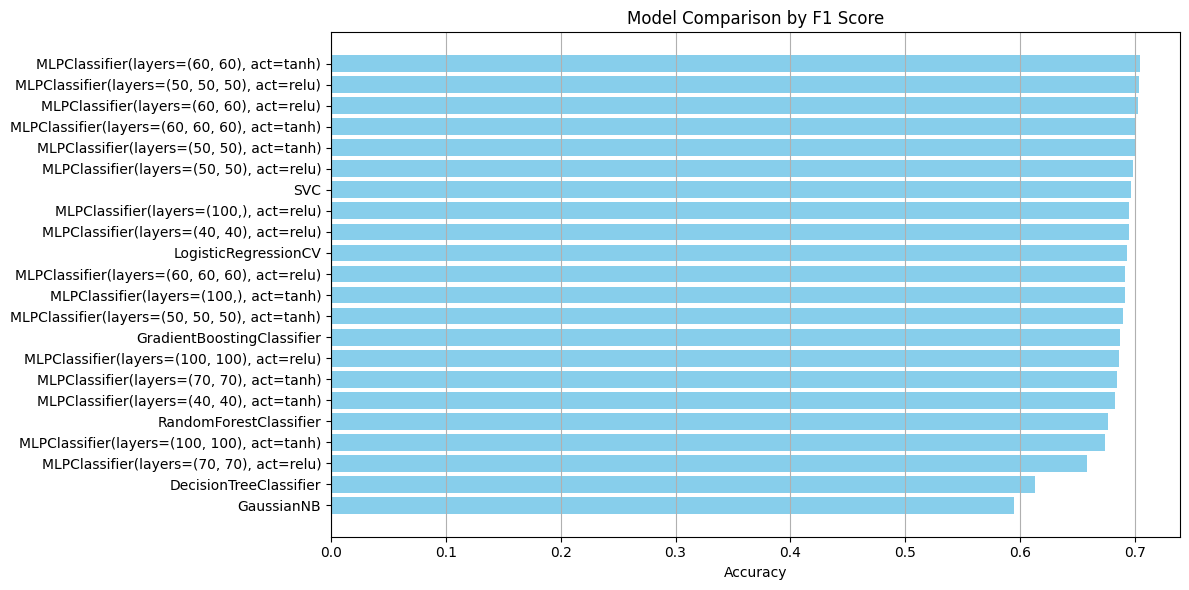

In [349]:
results = pipeline.cv_results_

mean_scores = results['mean_test_score']
params = results['params']

model_labels = []
for p in params:
    model = type(p['classifier']).__name__
    label = None
    if model == "SVC":
        label =f"{model}(kernel={p['classifier'].kernel})"
    if 'classifier__hidden_layer_sizes' in p and 'classifier__activation' in p:
        label = f"{model}(layers={p['classifier__hidden_layer_sizes']}, act={p['classifier__activation']})"
    else:
        label = f"{model}"
    model_labels.append(label)

sorted_indices = np.argsort(mean_scores)[::-1]
sorted_scores = mean_scores[sorted_indices]
sorted_labels = np.array(model_labels)[sorted_indices]

plt.figure(figsize=(12, 6))
plt.barh(sorted_labels, sorted_scores, color='skyblue')
plt.title("Model Comparison by F1 Score")
plt.xlabel("Accuracy")
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Selecting the best One

In [348]:
best_model = pipeline.best_estimator_.named_steps['classifier']
model_name = type(best_model).__name__

hyperparams = ""

if model_name == "SVC":
    hyperparams = f"(kernel='{best_model.kernel}')"
elif model_name == "RandomForestClassifier":
    hyperparams = f"(n_estimators={best_model.n_estimators}, max_depth={best_model.max_depth})"
elif model_name == "DecisionTreeClassifier":
    hyperparams = f"(max_depth={best_model.max_depth})"
elif model_name == "LogisticRegressionCV":
    hyperparams = f"(Cs={best_model.Cs})"
elif model_name == "GradientBoostingClassifier":
    hyperparams = f"(learning_rate={best_model.learning_rate}, max_depth={best_model.max_depth})"

print(
    f"The top-performing model is {model_name} with hyperparameters:\n{hyperparams}\nwith an accuracy of {pipeline.best_score_:.4f}."
)

The top-performing model is MLPClassifier with hyperparameters:

with an accuracy of 0.7041.


## Test Prediction for a Single Instance

In [369]:
student_instance = pd.DataFrame([{
    # ── Identification & admission ───────────────────────────────────────────────
    "Marital status": 1,                          # 1 = single
    "Application mode": 17,                       # 17 = DGES – national access contest
    "Application order": 5,                       # 5th choice of course
    "Course": 171,                                # 171 = Informatics Engineering (example)
    "Daytime/evening attendance\t": 1,              # 1 = day-time schedule

    # ── Prior schooling ─────────────────────────────────────────────────────────
    "Previous qualification": 1,                  # 1 = Portuguese secondary-school diploma
    "Previous qualification (grade)": 122.0,      # final HS grade (0–200 scale)
    "Nacionality": 1,                             # 1 = Portuguese

    # ── Parents’ schooling & jobs ───────────────────────────────────────────────
    "Mother's qualification": 19,                 # 19 = 12th grade completed
    "Father's qualification": 12,                 # 12 = 9th grade completed
    "Mother's occupation": 5,                     # 5 = services sector
    "Father's occupation": 9,                     # 9 = industry sector

    # ── Admission & demographic flags ───────────────────────────────────────────
    "Admission grade": 127.3,                     # entrance-exam grade (0–200)
    "Displaced": 1,                               # 1 = lives away from home town
    "Educational special needs": 0,               # 0 = no special-needs flag
    "Debtor": 0,                                  # 0 = no tuition debt
    "Tuition fees up to date": 1,                 # 1 = payments up to date
    "Gender": 1,                                  # 1 = male (0 = female)
    "Scholarship holder": 0,                      # 0 = no scholarship
    "Age at enrollment": 20,                      # 20 years old
    "International": 0,                           # 0 = domestic student

    # ── 1st-semester academic record ───────────────────────────────────────────
    "Curricular units 1st sem (credited)": 0,
    "Curricular units 1st sem (enrolled)": 0,
    "Curricular units 1st sem (evaluations)": 0,
    "Curricular units 1st sem (approved)": 0,
    "Curricular units 1st sem (grade)": 0.0,
    "Curricular units 1st sem (without evaluations)": 0,

    # ── 2nd-semester academic record ───────────────────────────────────────────
    "Curricular units 2nd sem (credited)": 0,
    "Curricular units 2nd sem (enrolled)": 0,
    "Curricular units 2nd sem (evaluations)": 0,
    "Curricular units 2nd sem (approved)": 0,
    "Curricular units 2nd sem (grade)": 0.0,
    "Curricular units 2nd sem (without evaluations)": 0,

    # ── Macro-economic context (Portugal, year of enrolment) ────────────────────
    "Unemployment rate": 10.8,    # in %
    "Inflation rate": 1.4,        # in %
    "GDP": 1.74                   # GDP growth %
    # 'Target' column intentionally left out – that’s what we want to predict
}])

In [370]:
dropout_pred = le.inverse_transform(pipeline.predict(student_instance))[0]

In [378]:
print(
    f"The student will likely {dropout_pred} "
    f"\n{'🚨The student is in a risk group — it’s time to act and help them graduate successfully!🚨' if dropout_pred == 'Dropout' else '✅The student looks on track — keep encouraging their progress!✅'}"
)

The student will likely Dropout 
🚨The student is in a risk group — it’s time to act and help them graduate successfully!🚨
